<a href="https://colab.research.google.com/github/gitudaniel/fastai-course-notes/blob/main/Collaborative_filtering_deep_dive.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install --upgrade fastai

     |████████████████████████████████| 188 kB 5.4 MB/s 
     |████████████████████████████████| 53 kB 2.3 MB/s 
  Attempting uninstall: fastai
    Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fastai-1.0.61


In [3]:
!pip install fastbook

     |████████████████████████████████| 720 kB 5.1 MB/s 
     |████████████████████████████████| 1.2 MB 10.9 MB/s 
     |████████████████████████████████| 46 kB 4.4 MB/s 
     |████████████████████████████████| 51 kB 331 kB/s 


In [4]:
from fastbook import *

- Say on Netflix you watch lots of movies that are science-fiction, full of action and made in the 1970s.

- Netflix may not know these particular properties of the films you have watched, but it would be able to see that other people that have watched the same films also tend to watch other movies that are science-fiction, full of action and made in the 1970s that you haven't watched.

- With this approach, we don't necessarily need to know anything about the movies, except who like to watch them.

- In this same respect, we can recommend things even if we don't know anything about what those things are, as long as we know who else has used/recommended things that are similar.

- In collaborative filtering we more commonly refer to items rather than products. Items could be links that you click on, diagnoses selected for patients etc.

- The key foundational idea is that of *latent factors*.

- Taking the Netflix example, latent factors are things that decide what kind of movies you want to watch that no one ever necessarily wrote down or labelled or communicated them in any way

# A first look at the data

- For this chapter, we will be working on the movie review problem using the MovieLens dataset.

- This dataset contains tens of millions of movie rankings (a combination of movie ID, user ID, and a numeric rating), although we'll just use a subset of 100,000 for our example

In [5]:
from fastai.collab import *
from fastai.tabular.all import *

path = untar_data(URLs.ML_100k)

- According to the `README`, the main table is in the file `u.data`.

- It is tab separated and the columns are respectively user, movie, rating and timestamp.

- Since those are not encoded, we need to indicate them when reading the file with pandas.

In [6]:
ratings = pd.read_csv(path/'u.data', delimiter='\t', header=None,
                      names=['user', 'movie', 'rating', 'timestamp'])
ratings.head()

,user,movie,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [7]:
n_users = 15
n_movies = 15

In [8]:
top_users = ratings['user'].value_counts().sort_values(ascending=False)[:15]

In [9]:
len(top_users)

15

In [10]:
top_movies = ratings['movie'].value_counts().sort_values(ascending=False)[:15]

In [11]:
pd.crosstab(top_users, top_movies, values=ratings['rating'], aggfunc='mean')

movie,392,507
user,,
403,5.0,NaN
435,NaN,4.0


In [12]:
top_users

405    737
655    685
13     636
450    540
276    518
416    493
537    490
303    484
234    480
393    448
181    435
279    434
429    414
846    405
7      403
Name: user, dtype: int64

In [13]:
n_users = 15
n_movies = 15

# list the ids of the most frequent users (those who rated the most movies)
most_frequent_users = list(ratings.user.value_counts().index[:n_users])
# grab all the ratings made by these most frequent users
denser_users = ratings[ratings.user.isin(most_frequent_users)]

# list the ids of the most frequent movies within this group of users
dense_users_most_rated = list(ratings.movie.value_counts().index[:n_movies])
# grab all the most frequent movies rated by the most frequent users
denser_movies = ratings[ratings.movie.isin(dense_users_most_rated)]

# plot the crosstab
pd.crosstab(denser_users.user, denser_movies.movie, values=ratings.rating, aggfunc='mean').fillna("")

movie,1,7,50,56,98,100,121,127,174,181,258,286,288,294,300
user,,,,,,,,,,,,,,,
7,,5,5,5,4,5,5,5,5,3,4,4,4.0,1,4
13,3,2,5,5,4,5,5,5,4,5,4,3,1.0,2,1
181,3,4,,,,3,4,,,,3,1,4.0,2,3
234,3,2,4,3,4,4,,4,3,3,2,3,3.0,3,3
276,5,5,5,5,5,5,4,5,5,5,5,,4.0,4,4
279,3,5,3,4,,4,4,,4,3,,,3.0,2,
303,5,4,5,5,5,5,3,5,5,5,4,5,4.0,4,1
393,3,4,5,2,,1,4,,,4,4,,3.0,4,
405,,,5,4,4,,,5,5,5,,,5.0,,


- We've just selected a few of the most popular movies, and users who watched the most movies for our crosstab example.

- The slots that are empty means the user has not rated the movie yet presumably because they have not watched it.

- The empty cells in the table are the things we would like our model to learn to fill in.

- For each user, we would like to figure out which of those movies they might be most likely to enjoy.

- If we knew for each user to what degree they liked each important category that a movie might fall into, such as genre, age, preferred directors and actors etc, and we knew the same information about each movie, then a simple way to fill in this table would be to multiply this information together for each movie and use a combination.

- For instance, assuming these factors range between -1 and 1, positive being high match and negative being low match, and the categories are science-fiction, action and old-movies, we could represent the movie The Last Skywalker as:

In [14]:
last_skywalker = np.array([0.98, 0.9, -0.9])

- Here for instance, we're scoring *very science fiction* as 0.98 and *very not old* as -0.9.

- We could represent a user who likes modern sci-fi action movies as:

In [15]:
user1 = np.array([0.9, 0.8, -0.6])

- ...and we can now calculate the match between this combination

In [16]:
(user1 * last_skywalker).sum()

2.1420000000000003

- When we multiply two vectors together and add up the results, this is known as the *dot product*.

- It is used a lot in machine learning, and forms the basis of matrix multiplication.

> jargon: **dot product**: the mathematical operation of multiplying the elements of two vectors together, and then summing up the result.

- On the other hand, we might represent the movie Casablanca as:

In [17]:
casablanca = np.array([-0.99, -0.3, 0.8])

- ...and the match between this combination is:

In [18]:
(user1 * casablanca).sum()

-1.611

- Since we don't know what the latent factors actually are, and we don't know how to score them for each user and movie, we should learn them

## Learning the latent factors

- There is surprisingly little distance from specifying the structure of a model, as we did in the last section, and learning one, since we can just use our general gradient descent approach.

- Step one of this approach is to randomly initialize some parameters.

- These parameters will be a set of latent factors for each user and movie.

- For illustrative purposes, let's use 5 latent factors.

- Step two is to calculate our predictions. We can take the matrix multplication of the row of a user's latent factors by the column of a movie's latent factors.

- NOTE: A matrix multiplication of a row by a column is identical to a dot product of two vectors.

- We can calculate a loss by comparing every one of our numbers here to every one of our numbers in the pandas `crosstab` and get the mean squared error

- We could then use SGD to find the best set of parameters (latent factors) for the user and movies.

- At each step SGD will calculate the match between each movie and each user using the dot product, and compare it to the actual rating that each user gave to each movie.

- It will then calculate the derivative of this value, and will step the weights by multiplying this by the learning rate.

- After doing this lots of times, the loss will get better and better, and the recommendations will also get better and better.

- To use the usual `Learner` fit function, we will need to get our data into `DataLoaders`.

## Creating the DataLoaders

- When showing the data, we would rather see the movie titles than their ids.

- The table `u.item` contains the corresponding id to title:

In [19]:
movies = pd.read_csv(path/'u.item', delimiter='|', encoding='latin-1',
                     usecols=(0, 1), names=('movie', 'title'), header=None)
movies.head()

,movie,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


- Next we merge it to our ratings to get the titles

In [20]:
ratings = ratings.merge(movies)
ratings.head()

,user,movie,rating,timestamp,title
0,196,242,3,881250949,Kolya (1996)
1,63,242,3,875747190,Kolya (1996)
2,226,242,5,883888671,Kolya (1996)
3,154,242,3,879138235,Kolya (1996)
4,306,242,5,876503793,Kolya (1996)


- We can then build a `DataLoaders` object from this table.

- By default, it takes the first column for user, the second for the item (here our movies) and the third for the ratings.

- We need to change the value of `item_name` in our case to use the titles instead of the ids:

In [21]:
# create a collaborative filtering dataloaders object from a dataframe
dls = CollabDataLoaders.from_df(ratings, item_name='title', bs=64)
dls.show_batch()

,user,title,rating
0,542,My Left Foot (1989),4
1,422,Event Horizon (1997),3
2,311,"African Queen, The (1951)",4
3,595,Face/Off (1997),4
4,617,Evil Dead II (1987),1
5,158,Jurassic Park (1993),5
6,836,Chasing Amy (1997),3
7,474,Emma (1996),3
8,466,Jackie Chan's First Strike (1996),3
9,554,Scream (1996),3


- In order to represent collaborative filtering in PyTorch, we can't just use the crosstab representation directly, especially if we want to fit into our deep learning framework.

- We can represent our movie and user latent factor tables as simple matrices:

In [22]:
dls.classes

{'title': ['#na#', "'Til There Was You (1997)", '1-900 (1994)', '101 Dalmatians (1996)', '12 Angry Men (1957)', '187 (1997)', '2 Days in the Valley (1996)', '20,000 Leagues Under the Sea (1954)', '2001: A Space Odyssey (1968)', '3 Ninjas: High Noon At Mega Mountain (1998)', '39 Steps, The (1935)', '8 1/2 (1963)', '8 Heads in a Duffel Bag (1997)', '8 Seconds (1994)', 'A Chef in Love (1996)', 'Above the Rim (1994)', 'Absolute Power (1997)', 'Abyss, The (1989)', 'Ace Ventura: Pet Detective (1994)', 'Ace Ventura: When Nature Calls (1995)', 'Across the Sea of Time (1995)', 'Addams Family Values (1993)', 'Addicted to Love (1997)', 'Addiction, The (1995)', 'Adventures of Pinocchio, The (1996)', 'Adventures of Priscilla, Queen of the Desert, The (1994)', 'Adventures of Robin Hood, The (1938)', 'Affair to Remember, An (1957)', 'African Queen, The (1951)', 'Afterglow (1997)', 'Age of Innocence, The (1993)', 'Aiqing wansui (1994)', 'Air Bud (1997)', 'Air Force One (1997)', 'Air Up There, The (199

In [23]:
n_users = len(dls.classes['user'])
n_movies = len(dls.classes['title'])
n_factors = 5

# randn -> normally distributed random numbers
user_factors = torch.randn(n_users, n_factors)
movie_factors = torch.randn(n_movies, n_factors)

- To calculate the result for a particular movie using a combination of movie and user, we have to look up the index of the movie in our movie latent factor matrix, and the index of the user in our user latent factor matrix, and then we can do our dot product between the two latent factor vectors.

- However, a *lookup in an index* is not an operation which our deep learning models know how to do.

- They know how to do matrix products, and activation functions.

- It turns out that we can represent look up in an index as a matrix product.

- The trick is to replace our indices with one hot encoded vectors.

- Here is an example of what happens if we multiply a vector by a one hot encoded vector representing the index three:

In [24]:
n_users

944

In [25]:
# one-hot encode the number 3 with n_users (944) classes
one_hot_3 = one_hot(3, n_users).float()

In [26]:
one_hot_3.shape

torch.Size([944])

In [27]:
user_factors.shape

torch.Size([944, 5])

In [28]:
user_factors.t().shape

torch.Size([5, 944])

- We transpose the user_factors tensor because in order for matrix multiplication to work, the number of columns in the first matrix must be equal to the number of rows in the second matrix.

In [29]:
user_factors.t() @ one_hot_3

tensor([-0.4586, -0.9915, -0.4052, -0.3621, -0.5908])

- It gives us the same vector as the one at index 3 in the matrix:

In [30]:
user_factors[3]

tensor([-0.4586, -0.9915, -0.4052, -0.3621, -0.5908])

- If we do that for a few indices at once, we will have a matrix of one-hot encoded vectors and that operation will be a matrix multiplication.

- This would be a perfectly acceptable way to build models using this kind of architecture, except that it would use a lot more memory and time than necessary.

- We know that there is no real underlying reason to store the one-hot encoded vector, or to search through it to find the occurence of the number one -- we should just be able to index into an array directly with an integer.

- Therefore, most deep learning libraries, including PyTorch, include a special layer which does just this; it indexes into a vector using an integer, but has its derivative calculated in such a way that it is identical to what it would have been if it had done a matrix multiplication with a one-hot encoded vector.

- This is called **embedding**

> jargon: **embedding layer**: multiplying a one hot encoded matrix, using the computational shortcut that implements it by simply indexing directly. The thing that you multiply the one hot encoded matrix by (or, using the computational shortcut, index into directly) is called the *embedding matrix*

- An embedding is a layer that has the computational speed of an array lookup and the same gradients as a matrix multiplication.

- It is basically a matrix multiplication with a one-hot encoded vector without having to actually create the one-hot encoded vector, you just need the indices

## Collaborative filtering from scratch

- The key idea in object-oriented programming is the *class*.

- We have been using classes such as DataLoader, string and Learner. 

- Below is an example of a simple Python class:

In [31]:
class Example:
  def __init__(self, a): self.a = a
  def say(self, x): return f'Hello {self.a}, {x}.'

- The most important piece of this is the special method called `__init__` (pronounced *dunder init*).

- In Python any method surrounded by double underscores is considered special. It indicates that there is some extra behavior associated with this method name.

- In the case of `__init__`, this is the method which Python will call when your new object is created.

- This is where you can set up any state that needs to be done upon object creation.

- Any parameters included when the user constructs an instance of your class will be passed to the `__init__` method as parameters.

- **Note:** the first parameter to any method defined inside a class is `self`, you can use this to get and set any attributes that you will need.

In [32]:
ex = Example('Sylvain')
ex.say('nice to meet you')

'Hello Sylvain, nice to meet you.'

- Creating a new PyTorch module requires inheriting from Module.

- *Inheritance* is an important Object-oriented concept that enables us to add additional behavior to an existing class. i.e. it gives us all the functionality of the inherited class and allows us to add some additional functionality

- PyTorch already provides a Module class, which provides some basic foundations that we want to build on.

- We add the name of the Module super class (class being inherited) after the name of the class we are defining.

- The final thing to know to create a PyTorch module, is that when your module is called, PyTorch will call a method in your class called `forward`, and will pass along to that any parameters included in the call.

- The actual computation is defined in the `forward()` method.

- Here is our dot product model:

In [33]:
class DotProduct(Module):
  def __init__(self, n_users, n_movies, n_factors):
    self.user_factors = Embedding(n_users, n_factors)
    self.movie_factors = Embedding(n_movies, n_factors)

  def forward(self, x):
    """The user and movie ids are passed as two columns.
    To grab the factors from an embedding, we call it like a function.
    The first axis is the mini-batch dimension but we want to sum
    over the other dimension (index 1 dimension).
    This function gives us the dot product for each rating for each user-movie
    combination.
    """
    users = self.user_factors(x[:,0])
    movies = self.movie_factors(x[:,1])
    return (users * movies).sum(dim=1)


In [34]:
x, y = dls.one_batch()
x.shape

torch.Size([64, 2])

- If we look at one batch of our data, it has the shape of 64 by 2 because there are 64 items in a mini-batch and each one has 2 independent variables (user_id and movie_id).

- Now that we have defined our architecture, and created our parameter matrices, we need to create a `Learner` to optimize our model.

- In the past, we have used special functions, such as `cnn_learner`, which set up everything for us for a particular application.

- Since we're doing everything from scratch, we'll use the plain `Learner` class.

- It doesn't do anything clever, it just stores away the data and the model you give it. It also doesn't know what loss function to use.

In [35]:
model = DotProduct(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())

- We are now ready to fit our model:

In [36]:
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,1.344786,1.279100,00:09
1,1.093332,1.109981,00:08
2,0.958258,0.990199,00:08
3,0.814234,0.894916,00:08
4,0.780714,0.882022,00:08


- The first thing we can do to make this model a little bit better is to force those predictions between 0 and 5.

- For this we just need to use the `sigmoid_range`, like in the previous chapter.

- When doing regression, like we are here, the numbers between 1 and 5 is like a countinuous value we're trying to get as close to as possible and should therefore tell fastai what the range is.

- It is empirically better to have the range go a little bit over 5, so we use `(0, 5.5)`.

In [37]:
class DotProduct(Module):
  def __init__(self, n_users, n_movies, n_factors, y_range=(0, 5.5) ):
    self.user_factors = Embedding(n_users, n_factors)
    self.movie_factors = Embedding(n_movies, n_factors)
    self.y_range = y_range

  def forward(self, x):
    """The user and movie ids are passed as two columns.
    To grab the factors from an embedding, we call it like a function.
    The first axis is the mini-batch dimension but we want to sum
    over the other dimension (index 1 dimension).
    This function gives us the dot product for each rating for each user-movie
    combination.
    """
    users = self.user_factors(x[:,0])
    movies = self.movie_factors(x[:,1])
    return sigmoid_range((users * movies).sum(dim=1), *self.y_range)

In [38]:
model = DotProduct(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,0.986799,1.005294,00:08
1,0.878134,0.918898,00:08
2,0.675850,0.875467,00:08
3,0.483372,0.877939,00:08
4,0.378927,0.881887,00:08


- This is a reasonable start but we can do better.

- One obvious missing piece is that some users are just more positive or negative in their recommendations than others, and some movies are just plain better or worse than others.

- In our dot product representation, we do not have any way to encode any of these things.

- If all you can say, for instance, about the movie is that it is very sci-fi, very action oriented, and very not old, then you don't have a way to say that most people like it.

- This is because at this point, we only have weights; we do not have biases.

- If we have a single number for each user which we add to our scores, and ditto for each movie, this handles the missing piece very nicely.

- First of all, let's adjust our model architecture:

In [39]:
class DotProductBias(Module):
  def __init__(self, n_users, n_movies, n_factors, y_range=(0, 5.5)):
    """An embedding of size 1 means we're just adding a single number."""
    self.user_factors = Embedding(n_users, n_factors)
    self.user_bias = Embedding(n_users, 1)
    self.movie_factors = Embedding(n_movies, n_factors)
    self.movie_bias = Embedding(n_movies, 1)
    self.y_range = y_range

  def forward(self, x):
    users = self.user_factors(x[:,0])
    movies = self.movie_factors(x[:,1])
    res = (users * movies).sum(dim=1, keepdim=True)
    res += self.user_bias(x[:,0]) + self.movie_bias(x[:,1])  # add the user and movie bias values
    return sigmoid_range(res, *self.y_range)

- Let's try training this and see how it goes:

In [40]:
model = DotProductBias(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,0.938634,0.952516,00:09
1,0.846664,0.865633,00:09
2,0.608090,0.865127,00:09
3,0.413482,0.887318,00:09
4,0.286971,0.894876,00:09


- Instead of getting better it got worse (at least at the end of training).

- If we look at both trainings carefully, we can see that the validation stopped improving in the middle and started to get worse.

- As we've seen, this is a clear indication of overfitting.

- In this case, there is no way to use data augmentation, so we'll have to use another regularization technique.

- Regularization is a set of techniques which allow us to use models with lots of parameters and train them for a long period of time but penalize them effectively for overfitting.

- One approach that might be helpful is *weight decay*

## Weight decay

- Weight decay or L2 regularization, consists in adding to your loss function the sum of all the parameters squared.

- **Why do that?** Because when we compute the gradients, it will add a contribution to them that will encourage the weights to be as small as possible.

- When the weights are part of the loss, one way to decrease the loss is to decrease the weights.

- **Why would it prevent overfitting?** The idea is that the larger the coefficients are, the more sharp canyons we will have in the loss function. i.e. when we have sharp valleys, a small change to the input can make a big change to the loss.

- Big coefficients are going to cause big changes in the loss for small changes to the parameters.

- If we take the basic example of parabola `y = a * (x**2)`, the larger a is, the narrower the parabola.

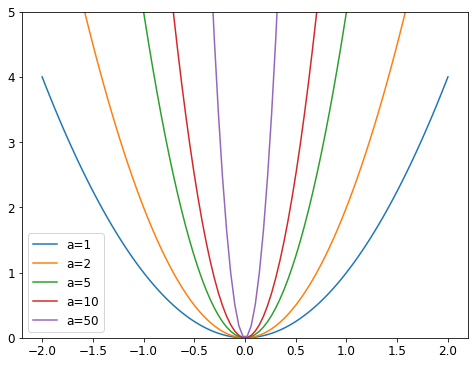

In [41]:
x = np.linspace(-2, 2, 100)
a_s = [1, 2, 5, 10, 50]
ys = [a * x**2 for a in a_s]
_, ax = plt.subplots(figsize=(8,6))

for a, y in zip(a_s, ys): ax.plot(x, y, label=f'a={a}')

ax.set_ylim([0, 5])
ax.legend()

- In a situation where a small change to the input can make a big change to the loss, you can basically fit all the data points close to exactly with really complex jagged functions with sharp changes which exactly tries to sit on each data point rather than finding a nice smooth surface which connects them all together or goes through them all.

- If we limit our weights by adding into the loss function the sum of the weights squared, it's going to fit less well on the training set because we're giving it less room to try anything that it wants to.

- The hope is that it will result in a better loss on the validation set i.e. it would generalize better.

- Weight decay `wd` is a parameter that controls the sum of squares we add to our loss (assuming `parameters` is a tensor of all parameters):

    ```python
    loss_with_wd = loss + wd * (parameters ** 2).sum()
    ```

- In practice, it would be very inefficient (and maybe numerically unstable) to compute that big sum and add it to the loss.

- From high school math, the derivative of `p**2` with respect to `p` is `2p`, so adding that big sum to our loss is exactly the same as doing:

    ```python
    parameters.grad += wd * 2 * parameters
    ```

- In practice, since `wd` is a parameter that we chose, we can just make it twice as big, so we don't even need the `* 2` in the above equation.

- To use weight decay in fastai, just pass `wd` in your call to fit:

In [42]:
model = DotProductBias(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.932776,0.961672,00:09
1,0.888625,0.882614,00:09
2,0.771066,0.832743,00:10
3,0.599807,0.822374,00:10
4,0.504981,0.822528,00:09


- The training loss becomes much worse but the validation loss becomes much better.

- In traditional statistical models, we try to avoid overfitting and increase generalization by decreasing the number of parameters.

- In a lot of mordern machine learning and certainly deep learning, we tend to instead use regularization because it gives us more flexibility and lets us use more non-linear functions and still reduces the capacity of the model.

## Creating our own Embedding module

- So far we've used `Embedding` without thinking about how it really works.

- Let's create the DotProductBias without using the `Embedding` class.

- We'll need a randomly initialized weight matrix for each of the embeddings.

- Recall that optimizers require that they can get all the parameters of a module from its `parameters()` method.

- However, this does not happen fully automatically. If we just add a tensor as an attribute to a `Module`, it will not be included in `parameters`:

In [43]:
class T(Module):
  def __init__(self): self.a = torch.ones(3)

L(T().parameters())

(#0) []

- To tell `Module` that we want to treat a tensor as parameters, we have to wrap it in the `nn.Parameter` class.

- This class doesn't actually add any functionality (other than automatically calling `requires_grad()` for us).

- It's only used as a "marker" to show what to include in `parameters()`:

In [44]:
class T(Module):
  def __init__(self): self.a = nn.Parameter(torch.ones(3))

L(T().parameters())

(#1) [Parameter containing:
tensor([1., 1., 1.], requires_grad=True)]

- All PyTorch modules use `nn.Parameter` for any trainable parameters, which is why we haven't needed to explicitly use this wrapper up until now:

In [45]:
class T(Module):
  def __init__(self): self.a = nn.Linear(1, 3, bias=False)

t = T()
L(t.parameters())

(#1) [Parameter containing:
tensor([[-0.3292],
        [-0.8623],
        [ 0.0592]], requires_grad=True)]

In [46]:
type(t.a.weight)

torch.nn.parameter.Parameter

- We can create a tensor as a parameter, with random initialization, like so:

In [47]:
torch.zeros(3)

tensor([0., 0., 0.])

In [48]:
def create_params(size):
  """Initialize a tensor of zeros of length size and randomly
  generate some some normally distributed random numbers with
  a mean of 0 and a standard deviation of 0.01
  """
  return nn.Parameter(torch.zeros(*size).normal_(0, 0.01))

- Let's use this to create `DotProductBias` again, but without `Embedding`:

In [49]:
class DotProductBias(Module):
  def __init__(self, n_users, n_movies, n_factors, y_range=(0, 5.5)):
    self.user_factors = create_params([n_users, n_factors])
    self.user_bias = create_params([n_users])
    self.movie_factors = create_params([n_movies, n_factors])
    self.movie_bias = create_params([n_movies])
    self.y_range = y_range

  def forward(self, x):
    users = self.user_factors[x[:,0]]
    movies = self.movie_factors[x[:,1]]
    res = (users*movies).sum(dim=1)
    res += self.user_bias[x[:,0]] + self.movie_bias[x[:,1]]
    return sigmoid_range(res, *self.y_range)

- With the manual embedding layer, we don't have to do anything with gradient ourselves because PyTorch can figure out the gradients automatically from the `nn.Parameters`.

- Let's train it again to check it's around the same results we saw in the previous section:

In [50]:
model = DotProductBias(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.929254,0.953444,00:09
1,0.865246,0.878304,00:09
2,0.720294,0.838921,00:09
3,0.582796,0.829129,00:09
4,0.474043,0.829031,00:09


- Now, let's look at what the model has learnt

## Interpreting embeddings and biases

- Our model is already useful, in that it can provide us with recommendations of movies for our users -- but it is also interesting to see what parameters it has discovered.

- The easiest to interpret are the biases.

- Here are the movies with the lowest values in the bias vector:

In [51]:
# squeeze transforms a 3-D tensor to a 2-D tensor by removing
# a dimension from the tensor
# https://stackoverflow.com/a/65806552
movie_bias = learn.model.movie_bias.squeeze()
idxs = movie_bias.argsort()[:5]
[dls.classes['title'][i] for i in idxs]

['Lawnmower Man 2: Beyond Cyberspace (1996)',
 'Children of the Corn: The Gathering (1996)',
 'Mortal Kombat: Annihilation (1997)',
 'Amityville 3-D (1983)',
 'Beautician and the Beast, The (1997)']

- What this is saying is, that for these movies, even when a user is very well matched to its latent factors, they still generally don't like it.

- We could have simply sorted movies directly by the average rating, but looking at their learned bias tells us something much more interesting.

- It tells us not just whether a movie is of a kind that people tend not to enjoy watching, but that people do not like watching it even if it is of a kind that they would otherwise enjoy.

- By that same token, here are the movies with the highest bias

In [52]:
movie_bias = learn.model.movie_bias.squeeze()
idxs = movie_bias.argsort(descending=True)[:5]
[dls.classes['title'][i] for i in idxs]

['Titanic (1997)',
 'Shawshank Redemption, The (1994)',
 'Silence of the Lambs, The (1991)',
 'L.A. Confidential (1997)',
 "Schindler's List (1993)"]

- Movies with the highest bias are movies that people liked more than they expected despite not being a fan of the genre or actor in general.

- It is not quite so easy to directly interpret the embedding matrices. There's just too many factors for a human to look at.

- There is a technique which can pull out the most important underlying directions in such a matrix, called *principal component analysis (PCA)*

#### Representation of movies on the two strongest PCA components

- Use PCA to get the top 3 latent factors and plot the top 2

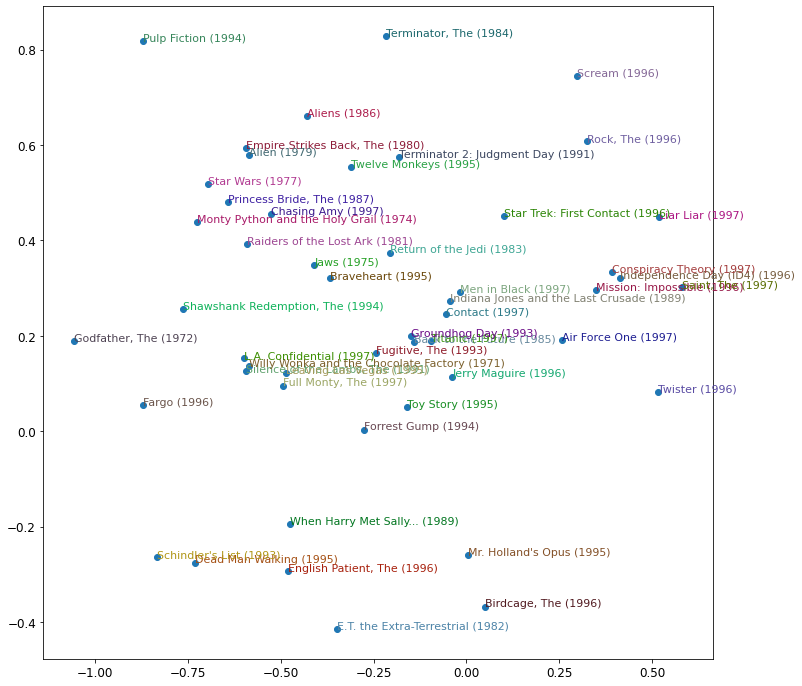

In [53]:
g = ratings.groupby('title')['rating'].count()
top_movies = g.sort_values(ascending=False).index.values[:1000]
top_idxs = tensor([learn.dls.classes['title'].o2i[m] for m in top_movies])
movie_w = learn.model.movie_factors[top_idxs].cpu().detach()
movie_pca = movie_w.pca(3)
fac0, fac1, fac2 = movie_pca.t()
idxs = np.random.choice(len(top_movies), 50, replace=False)
idxs = list(range(50))
x = fac0[idxs]
y = fac2[idxs]
plt.figure(figsize=(12,12))
plt.scatter(x,y)
for i, x, y in zip(top_movies[idxs], x, y):
  plt.text(x, y, i, color=np.random.rand(3)*0.7, fontsize=11)
plt.show()

- We can see that the model seems to have discovered a concept of *classic* versus *pop culture* movies or perhaps it is critically acclaimed.

> j: no matter how many models I train, I never stop getting moved and surprised by how these randomly initialised bunches of numbers, trained with such simple mechanics, managed to discover things about my data all by themselves. It almost seems like cheating, that I can create code which does useful things, without ever actually telling it how to do those things!

- We defined our model from scratch to teach what's inside, but we can directly use the fastai library to build it.

## Using fastai.collab

- fastai can create and train a collaborative filtering model using the exact structure shown above using `collab_learner`:

In [54]:
learn = collab_learner(dls, n_factors=50, y_range=(0, 5.5))

In [55]:
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.939463,0.954959,00:10
1,0.841215,0.876151,00:10
2,0.724404,0.832099,00:10
3,0.597228,0.816953,00:09
4,0.481373,0.817286,00:09


- The names of the layers can be seen by printing the model

In [56]:
learn.model

EmbeddingDotBias(
  (u_weight): Embedding(944, 50)
  (i_weight): Embedding(1665, 50)
  (u_bias): Embedding(944, 1)
  (i_bias): Embedding(1665, 1)
)

- We can use these to replicate any of the analyses we did in the previous section, for instance:

In [57]:
movie_bias = learn.model.i_bias.weight.squeeze()
idxs = movie_bias.argsort(descending=True)[:5]
[dls.classes['title'][i] for i in idxs]

['L.A. Confidential (1997)',
 'Titanic (1997)',
 'Shawshank Redemption, The (1994)',
 'Silence of the Lambs, The (1991)',
 'Rear Window (1954)']

- Another interesting thing we can do with these learned embeddings is look at distance.

## Embedding distance

- On a two-dimensional map, we can calculate the distance between two coordinates using the Pythagoras formula: $\sqrt{x^2 + y^2}$ (assuming the x and y are the distances between coordinates on each axis).

- For a 50 dimensional embedding we can do exactly the same thing, except that we add up the squares of all 50 of the coordinate distances.

- If there were two movies that were nearly identical, then their embedding vectors would also have to be nearly identical, because the users that would like them would be nearly exactly the same.

- There is a more general idea here: movie similarity can be defined by the similarity of users that like those movies.

- This directly means that the distance between two movies' embedding vectors can define that similarity.

- We can use this to find the movie most similar to *Silence of the Lambs*:

In [58]:
movie_factors = learn.model.i_weight.weight
idx = dls.classes['title'].o2i['Silence of the Lambs, The (1991)']
distances = nn.CosineSimilarity(dim=1)(movie_factors, movie_factors[idx][None])
idx = distances.argsort(descending=True)[1]
dls.classes['title'][idx]

'Before the Rain (Pred dozhdot) (1994)'

- Now that we have successfully trained a model, let's see how to make recommendations to a new user we have no data on.

## Bootstrapping a collaborative filtering model

- The biggest challenge with using collaborative filtering models in practice is the *bootstrapping problem*.

- The most extreme version of this problem is when you have no users, and therefore no history to learn from. What products do you recommend to your very first user?

- Even as a well established company with a long history of user transactions, the question still exists:
    - What do you do when a new user signs up?
    - What do you do when you add a new product to your portfolio?

- There is no magic solution to this problem.

- You could assign new users the mean of all of the embedding vectors of your other users, but this has the problem that that particular combination of latent factors may not at all be common (for example, the average of science-fiction factor may be high, and the average for the action factor may be low, but it is not that common to find people who like science-fiction without action.

- Better would be to pick some particular user to represent average taste.

- Better still is to use a tabular model based on user meta data to construct your initial embedding vector.

- When a user signs up, think about what questions you could ask them that could help you understand their tastes.

- You can then create a model where the dependent variable is a user's embedding vector and the independent variables are the results of the questions that you ask them, along with their sign up metadata.

- You may have noticed that when you sign up for services such as Spotify and Netflix, they tend to ask you a few questions about what genres of movie or music you like; this is how they come up with your initial collaborative filtering recommendations.

- One thing to be careful about is that a small number of extremely enthusiastic users may end up effectively setting the recommendations for your whole user base.

- In movie recommendation systems, people that watch anime tend to watch a whole lot of it, and don't watch very much else, and spend a lot of time putting their ratings on websites.

- As a result, anime tends to be heavily overrepresented in a lot of *best ever movies* lists.

- In this case there is a very obvious problem of representation bias, but if the bias is occurring in latent factors then it may not be obvious at all.

- Such a problem can change the entire makeup of your userbase and the behavior of your system.

- This is particularly true because of positive feedback loops. If a small number of users tend to set the direction of your recommendation system, then they are naturally going to attract more people like them to your system amplifying the representation bias.

- This type of bias has a natural tendency to be amplified exponentially.

- In a self-reinforcing system like this, we should probably expect these kind of feedback loops to be the norm, not the exception.

- You should assume that you will see them, plan for that, and identify up front how you will deal with these issues.

- Try to think about all the ways in which feedback loops may be represented in your system and how you might be able to identify them in your data.

- In the end, it's all about ensuring there are humans in the loop; that there is careful monitoring, and a gradual and thoughtful rollout (how to avoid disaster when rolling out any kind of machine learning system).

- Our dot product model works quite well, and is the basis of many real-world recommendation systems.

- This approach to collaborative filtering is known as *probabilistic matrix factorization (PMF)*.

- Another approach that generally works similarly well given the same data is deep learning.

## Deep Learning for Collaborative Filtering

- To turn our architecture into a deep learning model, the first step is to take the results of the embedding lookup, and concatenating those activations together.

- This gives us a matrix which we can then pass through linear layers and nonlinearities in the usual way.

- Since we'll be concatenating the embedding matrices, rather than taking their dot product, that means that the two embedding matrices can have different sizes (i.e. different numbers of latent factors).

- fastai has a function `get_emb_sz` that returns recommended sizes for embedding matrices for your data, based on a heuristic that fastai has found tends to work well in practice:

In [59]:
embs = get_emb_sz(dls)
embs

[(944, 74), (1665, 102)]

- Let's implement this class:

In [67]:
class CollabNN(Module):
  def __init__(self, user_sz, item_sz, y_range=(0,5.5), n_act=100):
    self.user_factors = Embedding(*user_sz)
    self.item_factors = Embedding(*item_sz)
    self.layers = nn.Sequential(
        nn.Linear(user_sz[1]+item_sz[1], n_act),
        nn.ReLU(),
        nn.Linear(n_act, 1)
    )
    self.y_range = y_range

  def forward(self, x):
    embs = self.user_factors(x[:,0]),self.item_factors(x[:,1])
    x = self.layers(torch.cat(embs, dim=1))
    return sigmoid_range(x, *self.y_range)

In [68]:
model = CollabNN(*embs)

- `CollabNN` creates our `Embedding` layers in the same way as previous classes in this chapter, except that we now use the `embs` sizes.

- Then `self.layers` is identical to the mini neural net we created in MNIST from scratch.

- In `forward`, we apply the embeddings, concatenate the results, and pass it through the mini neural net.

- Finally we apply `sigmoid_range` as we have in previous models.

- Let's see if it trains:

In [69]:
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3, wd=0.01)

epoch,train_loss,valid_loss,time
0,0.908817,0.967997,00:13
1,0.896155,0.906095,00:14
2,0.843105,0.883797,00:12
3,0.834041,0.873746,00:12
4,0.767635,0.874610,00:13


- fastai provides this model in fastai.collab if you pass `use_nn=True` in your call to `collab_learner` (including calling `get_emb_sz` for you), plut it lets you easily create more layers.

- For instance, here we're creating two hidden layers, of size 100 and 50 respectively:

In [70]:
learn = collab_learner(dls, use_nn=True, y_range=(0, 5.5), layers=[100, 50])
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.969446,0.980209,00:14
1,0.925636,0.910888,00:14
2,0.868476,0.887316,00:15
3,0.828628,0.857697,00:16
4,0.761050,0.860096,00:14


In [72]:
learn.model

EmbeddingNN(
  (embeds): ModuleList(
    (0): Embedding(944, 74)
    (1): Embedding(1665, 102)
  )
  (emb_drop): Dropout(p=0.0, inplace=False)
  (bn_cont): BatchNorm1d(0, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): LinBnDrop(
      (0): Linear(in_features=176, out_features=100, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): LinBnDrop(
      (0): Linear(in_features=100, out_features=50, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): LinBnDrop(
      (0): Linear(in_features=50, out_features=1, bias=True)
    )
    (3): SigmoidRange(low=0, high=5.5)
  )
)

- `learn.model` is an object of type `EmbeddingNN`.

- Let's take a look at fastai's code for this class:

In [73]:
@delegates(TabularModel)
class EmbeddingNN(TabularModel):
  def __init__(self, emb_szs, layers, **kwargs):
    super().__init__(emb_szs, layers=layers, n_cont=0, out_sz=1, **kwargs)

- This class inherits from `TabularModel`, which is where it gets all its functionality from.

- In `__init__`, it calls the same method in `TabularModel`, passing `n_cont=0` (no continuous variables) and `out_sz=1`; other than that, it only passes along whatever arguments it received.

- Although the results of `EmbeddingNN` are a bit worse than the dot product approach (which shows the power of carefully using an architecture for a domain), it does allow us to do something very important: we can now directly incorporate other user and movie information, time, and other information that may be relevant to the recommendation.

- That's exactly what `TabularModel` does.

- In fact, we've now seen that `EmbeddingNN` is just a `TabularModel` with `n_cont=0` and `out_sz=1`

### Sidebar: kwargs and delegates

- `EmbeddingNN` includes `**kwargs` as a parameter to `__init__`.

- We're using `**kwargs` to avoid having to write all the arguments to `TabularModel` a second time, and keep them in sync.

- However, this makes our API quite difficult to work with, because now Jupyter Notebook doesn't know what parameters are available, so things like tab-completion of parameter names and popup lists of signatures won't work.

- Fastai resolves this by providing a special `@delegates` decorator, which automatically changes the signature of the class or function (`EmbeddingNN` in this case) to insert all of its keyword arguments into the signature.